<center>
  <h1 style="color:RED;background-color:white;padding:10px; border-radius:10px; font-family:Georgia;width:60%">
     ARIMA 
  </h1>
  <h3 style="color:#d6633c;background-color:white; padding:5px; border-radius:10px;width:30%">" Cas de S&P500 "</h3>
</center>
<hr style="border:2px solid #613527;"/>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

### 1. CHARGEMENT DES DONNÉES

In [2]:
ticker = "^GSPC"
data = yf.download(ticker, start="2020-01-01", end="2024-12-31")

data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^GSPC,^GSPC,^GSPC,^GSPC,^GSPC
Date,,,,,
2020-01-02,3257.850098,3258.139893,3235.530029,3244.669922,3459930000
2020-01-03,3234.850098,3246.149902,3222.340088,3226.360107,3484700000
2020-01-06,3246.280029,3246.840088,3214.639893,3217.550049,3702460000
2020-01-07,3237.179932,3244.909912,3232.429932,3241.860107,3435910000
2020-01-08,3253.050049,3267.070068,3236.669922,3238.590088,3726840000


In [3]:
prices = data['Close'].dropna()


print(f"Données téléchargées : {len(prices)} observations")
print(f"Période : {prices.index[0]} à {prices.index[-1]}")
print(f"Prix moyen : ${prices.mean().item():.2f}")

Données téléchargées : 1257 observations
Période : 2020-01-02 00:00:00 à 2024-12-30 00:00:00
Prix moyen : $4258.32


### 2. DIVISION DES DONNÉES

In [4]:
split_date = "2024-01-01"
train = prices.loc[:split_date]
test  = prices.loc[split_date:]

print(f"Apprentissage : {len(train)} observations")
print(f"Test : {len(test)} observations")

Apprentissage : 1006 observations
Test : 251 observations


In [5]:
train.to_csv('sp500_train.csv')
test.to_csv('sp500_test.csv')

## Analyse qualitative

### 3. VISUALISATION DE LA SÉRIE

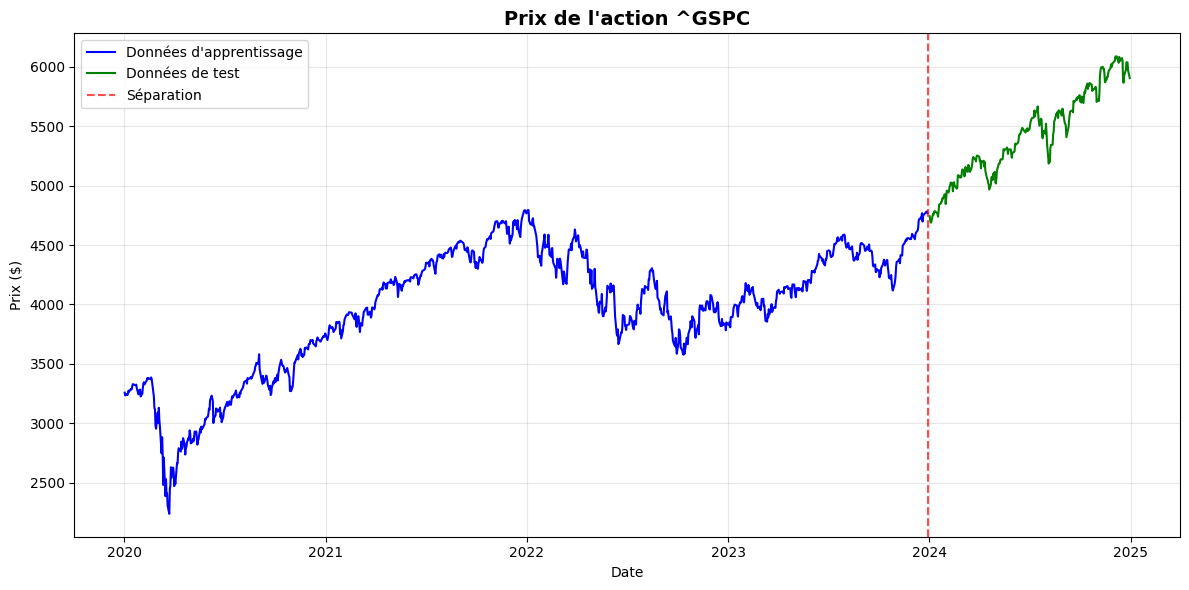

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, 'b-', label='Données d\'apprentissage', linewidth=1.5)
plt.plot(test.index, test.values, 'g-', label='Données de test', linewidth=1.5)
plt.axvline(x=train.index[-1], color='red', linestyle='--', alpha=0.7, label='Séparation')
plt.title(f'Prix de l\'action {ticker}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prix ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 4. ANALYSE DE SAISONNALITÉ

In [7]:
# Analyse par mois
train_df = train.copy()
train_df = train_df.rename(columns={train_df.columns[0]: 'price'})

train_df['month'] = train_df.index.month
train_df['dayofyear'] = train_df.index.dayofyear
train_df['year'] = train_df.index.year

train_df.head()

Ticker,price,month,dayofyear,year
Date,,,,
2020-01-02,3257.850098,1,2,2020
2020-01-03,3234.850098,1,3,2020
2020-01-06,3246.280029,1,6,2020
2020-01-07,3237.179932,1,7,2020
2020-01-08,3253.050049,1,8,2020


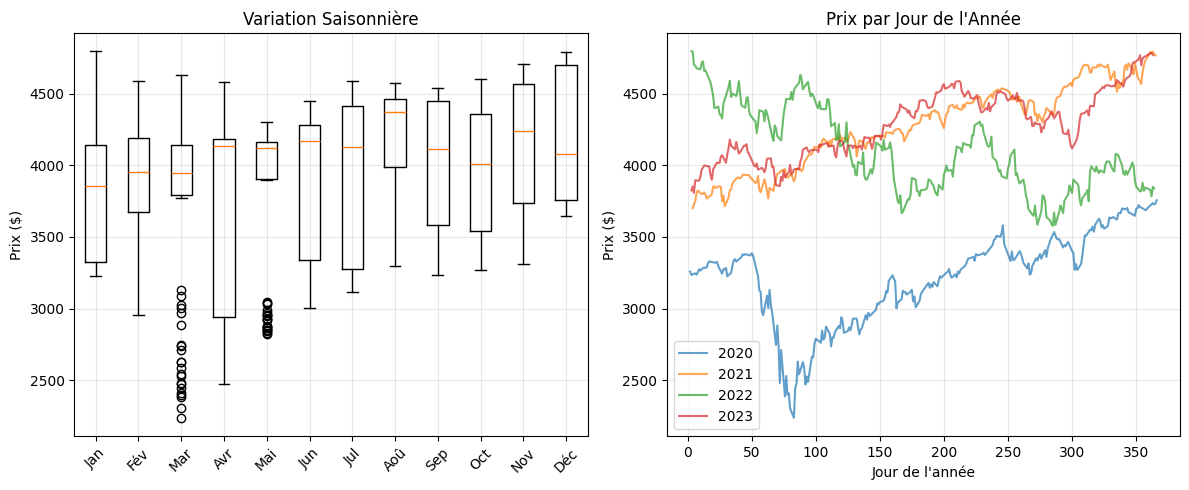

Observation : La série ne présente pas de saisonnalité claire


In [8]:
plt.figure(figsize=(12, 5))
# Boxplot mensuel
plt.subplot(1, 2, 1)
monthly_data = [train_df[train_df['month'] == i]['price'].values for i in range(1, 13)]
plt.boxplot(monthly_data, labels=['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun',
                                  'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'])
plt.title('Variation Saisonnière')
plt.ylabel('Prix ($)')
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)

# Prix par jour de l'année
plt.subplot(1, 2, 2)


for year in train_df['year'].unique():
    year_data = train_df[train_df['year'] == year]
    plt.plot(year_data['dayofyear'], year_data['price'], alpha=0.7, label=str(year))
plt.title('Prix par Jour de l\'Année')
plt.xlabel('Jour de l\'année')
plt.ylabel('Prix ($)')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Observation : La série ne présente pas de saisonnalité claire")

### 5. TEST DE STATIONNARITÉ (Test de Dickey-Fuller (ADF))

In [9]:
def test_stationarity(series, title="Série"):
    result = adfuller(series.dropna())
    print(f"\nTest ADF - {title}")
    print(f"Statistique ADF : {result[0]:.6f}")
    print(f"p-value : {result[1]:.6f}")
    
    if result[1] <= 0.05:
        print("Résultat : Série STATIONNAIRE")
        return True
    else:
        print("Résultat : Série NON-STATIONNAIRE")
        return False

print("\n5. TEST DE STATIONNARITÉ")
print("-" * 30)

is_stationary = test_stationarity(train, "Série originale")



5. TEST DE STATIONNARITÉ
------------------------------

Test ADF - Série originale
Statistique ADF : -1.406807
p-value : 0.579008
Résultat : Série NON-STATIONNAIRE


### 6. DIFFÉRENCIATION


6. DIFFÉRENCIATION
------------------------------


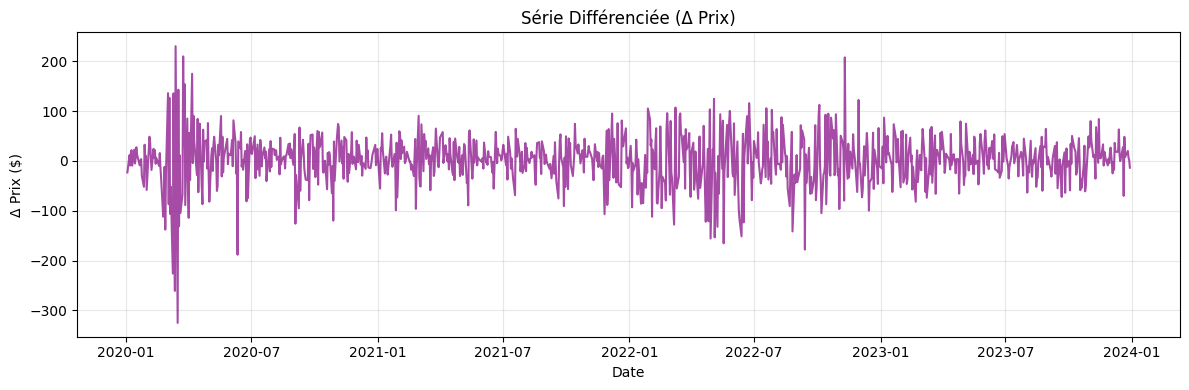


Test ADF - Série différenciée
Statistique ADF : -9.699619
p-value : 0.000000
Résultat : Série STATIONNAIRE


In [11]:
print("\n6. DIFFÉRENCIATION")
print("-" * 30)

# Différence première
train_diff = train.diff().dropna()

plt.figure(figsize=(12, 4))
plt.plot(train_diff.index, train_diff.values, 'purple', alpha=0.7)
plt.title('Série Différenciée (Δ Prix)')
plt.xlabel('Date')
plt.ylabel('Δ Prix ($)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Test sur série différenciée
is_stationary_diff = test_stationarity(train_diff, "Série différenciée")
series_for_analysis = train_diff

### 7. CORRÉLOGRAMMES ACF ET PACF

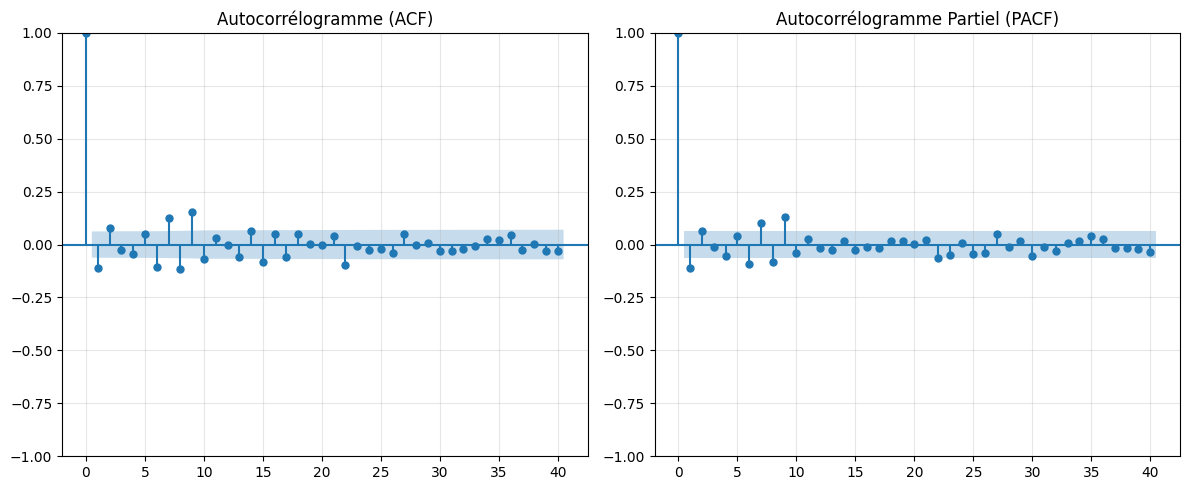

Analyse des corrélogrammes pour identifier les ordres p et q


In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ACF
plot_acf(series_for_analysis, lags=40, ax=axes[0], title='Autocorrélogramme (ACF)')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(series_for_analysis, lags=40, ax=axes[1], title='Autocorrélogramme Partiel (PACF)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Analyse des corrélogrammes pour identifier les ordres p et q")


### 8. SÉLECTION MANUELLE DU MODÈLE ARIMA

In [13]:
# Fonction pour évaluer les modèles ARIMA
def evaluate_arima_model(data, order):
    try:
        model = ARIMA(data, order=order)
        fitted_model = model.fit()
        return fitted_model.aic, fitted_model
    except:
        return float('inf'), None



In [14]:
print("Recherche du meilleur modèle ARIMA...")

Recherche du meilleur modèle ARIMA...


D’après le graphe, on remarque que les coefficients 𝑝 et 𝑞 sont respectivement égaux à 2 et 3.
Le paramètre 𝑑 est souvent compris entre 0 et 2.

In [15]:
# Grille de recherche limitée 
results = []
max_p = 3
max_q = 4
max_d = 3
for p in range(0, max_p):  # max_p = 2 comme dans le rapport
    for d in range(0, max_d):
        for q in range(0, max_q):  # max_q = 2 comme dans le rapport
            aic, model = evaluate_arima_model(train, (p, d, q))
            if aic != float('inf'):
                results.append((p, d, q, aic, model))


 On retiendra le modèle qui possède le plus petit AIC ou BIC.


In [16]:
# Tri par AIC
results.sort(key=lambda x: x[3])


In [17]:
# Affichage des 5 meilleurs modèles
print("\nTop 5 des modèles :")
print("p\td\tq\tAIC")
print("-" * 25)
for i, (p, d, q, aic, _) in enumerate(results[:5]):
    marker = " ← MEILLEUR" if i == 0 else ""
    print(f"{p}\t{d}\t{q}\t{aic:.2f}{marker}")


Top 5 des modèles :
p	d	q	AIC
-------------------------
2	2	3	10662.16 ← MEILLEUR
2	1	2	10663.94
2	2	2	10694.63
1	2	3	10698.52
2	2	1	10701.01


In [18]:
# Sélection du meilleur modèle
best_p, best_d, best_q, best_aic, fitted_model = results[0]
best_order = (best_p, best_d, best_q)

print(f"\nMeilleur modèle sélectionné : ARIMA{best_order}")
print(f"AIC : {best_aic:.2f}")

print("\nRésumé du modèle :")
print(fitted_model.summary().tables[1])


Meilleur modèle sélectionné : ARIMA(2, 2, 3)
AIC : 10662.16

Résumé du modèle :
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7645      0.032    -55.447      0.000      -1.827      -1.702
ar.L2         -0.8896      0.029    -30.162      0.000      -0.947      -0.832
ma.L1          0.6834      0.085      8.052      0.000       0.517       0.850
ma.L2         -0.8972      0.126     -7.120      0.000      -1.144      -0.650
ma.L3         -0.7858      0.070    -11.212      0.000      -0.923      -0.648
sigma2      2351.0124    188.468     12.474      0.000    1981.621    2720.404


### 9. ANALYSE DES RÉSIDUS

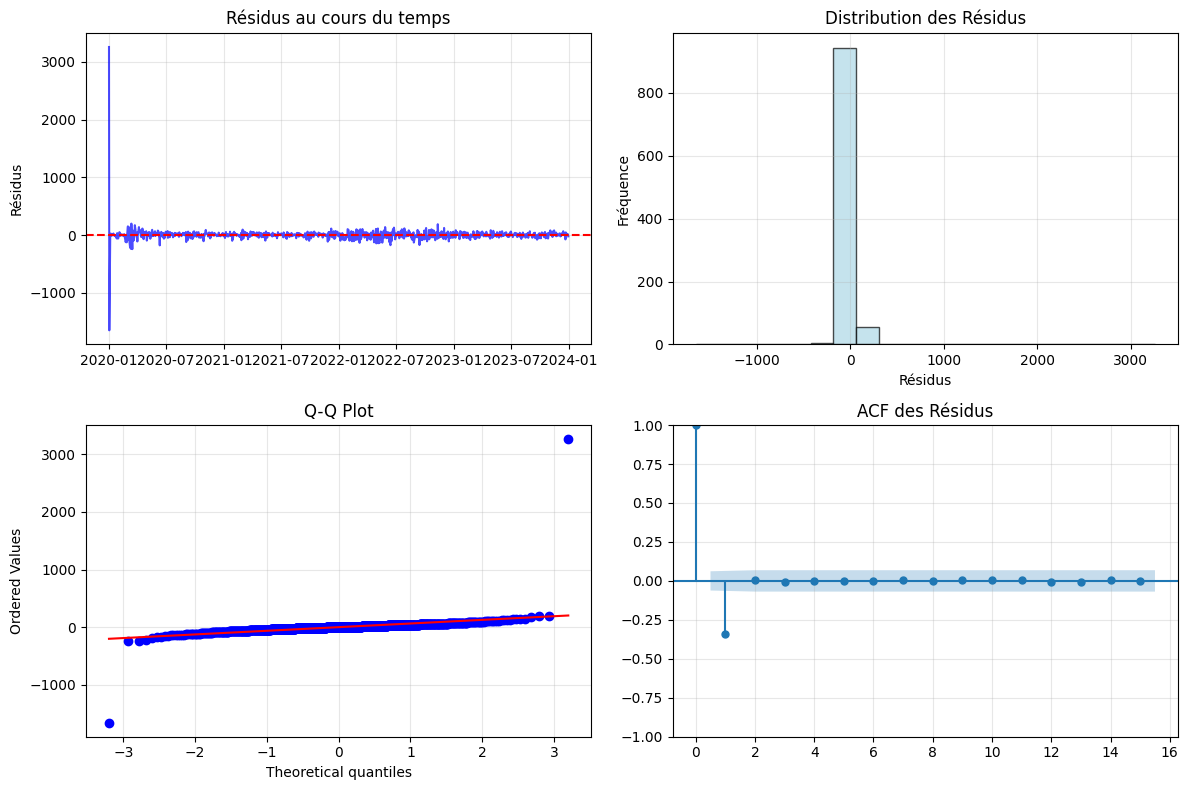

Les résidus semblent suivre une distribution normale et être non-corrélés


In [19]:
residuals = fitted_model.resid

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Résidus dans le temps
axes[0,0].plot(residuals.index, residuals.values, 'b-', alpha=0.7)
axes[0,0].axhline(y=0, color='red', linestyle='--')
axes[0,0].set_title('Résidus au cours du temps')
axes[0,0].set_ylabel('Résidus')
axes[0,0].grid(True, alpha=0.3)

# Distribution des résidus
axes[0,1].hist(residuals, bins=20, alpha=0.7, color='lightblue', edgecolor='black')
axes[0,1].set_title('Distribution des Résidus')
axes[0,1].set_xlabel('Résidus')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].grid(True, alpha=0.3)

# Q-Q plot
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot')
axes[1,0].grid(True, alpha=0.3)

# ACF des résidus
plot_acf(residuals, lags=15, ax=axes[1,1], title='ACF des Résidus')
axes[1,1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
print("Les résidus semblent suivre une distribution normale et être non-corrélés")

### 10. PRÉVISIONS

In [20]:
# Génération des prévisions
n_forecast = len(test)
forecast = fitted_model.forecast(steps=n_forecast)
forecast_ci = fitted_model.get_forecast(steps=n_forecast).conf_int()

In [29]:
forecast.to_csv("sp500_forecast2024.csv")

In [21]:
conf_df = pd.DataFrame({
    "Date": test.index,  # or forecast.index if that's your datetime index
    "Forecast": forecast.values,
    "Lower_95": forecast_ci.iloc[:, 0],
    "Upper_95": forecast_ci.iloc[:, 1]
})
conf_df.to_csv("sp500_confidence.csv", index=False)


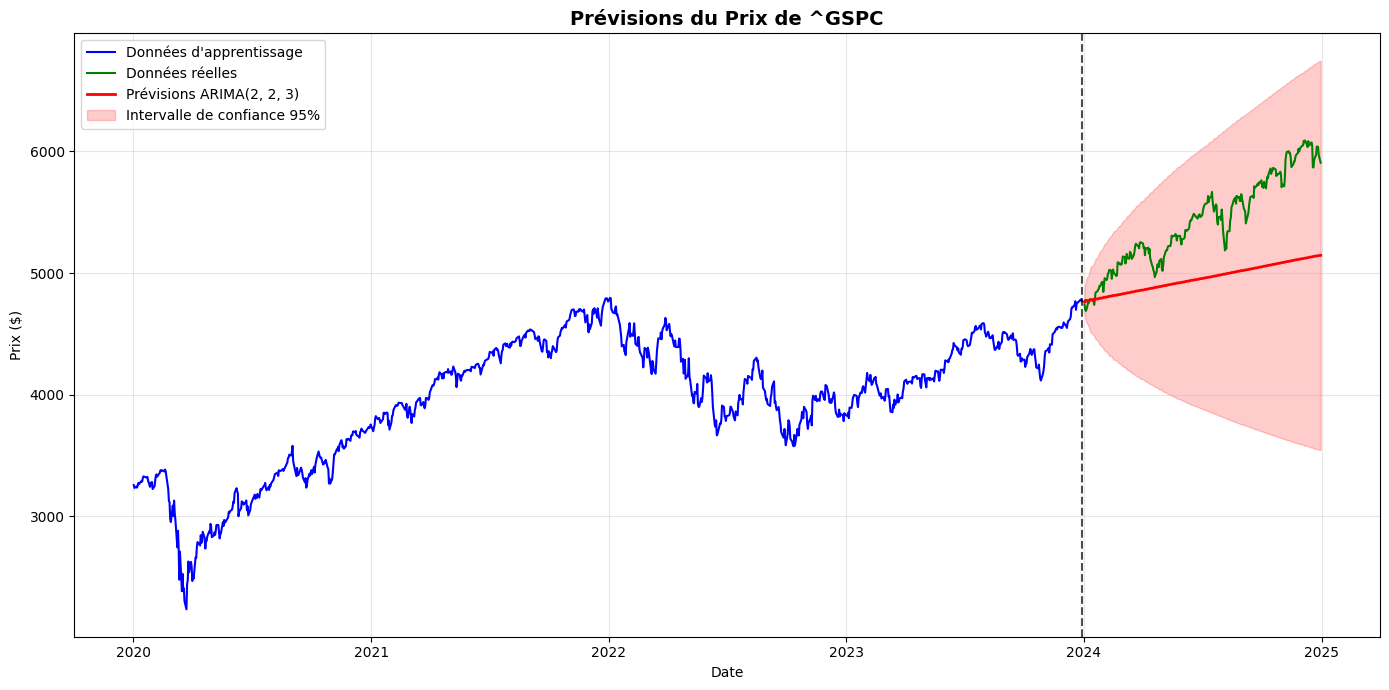

In [22]:
# Visualisation des prévisions
plt.figure(figsize=(14, 7))

# Données d'apprentissage
plt.plot(train.index, train.values, 'b-', label='Données d\'apprentissage', linewidth=1.5)

# Données réelles de test
plt.plot(test.index, test.values, 'g-', label='Données réelles', linewidth=1.5)

# Prévisions
plt.plot(test.index, forecast.values, 'r-', label=f'Prévisions ARIMA{best_order}', linewidth=2)

# Intervalle de confiance
plt.fill_between(test.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='Intervalle de confiance 95%')

plt.axvline(x=train.index[-1], color='black', linestyle='--', alpha=0.7)
plt.title(f'Prévisions du Prix de {ticker}', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prix ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

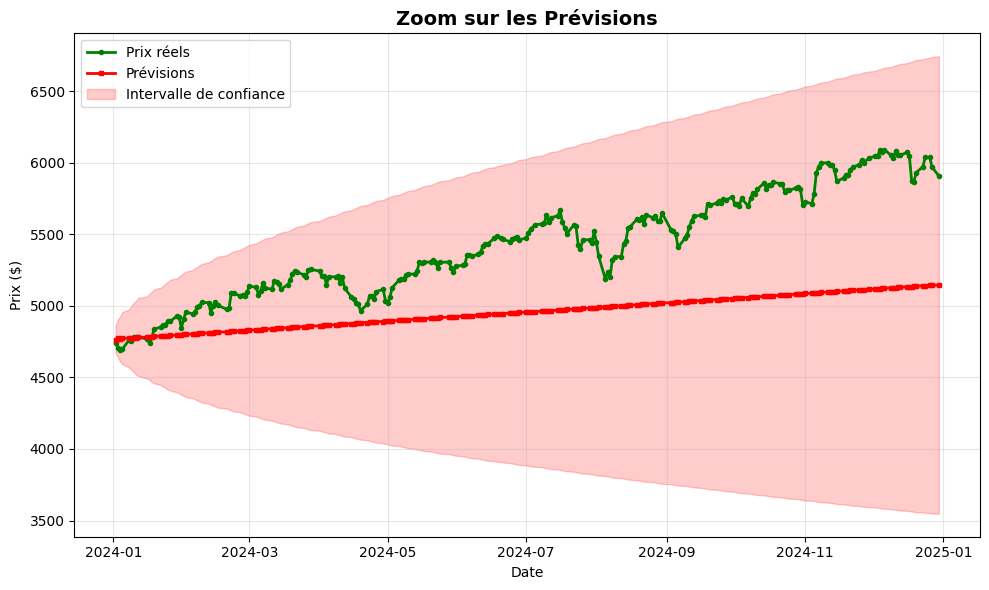

In [23]:
# Focus sur la période de prévision
plt.figure(figsize=(10, 6))
plt.plot(test.index, test.values, 'g-', label='Prix réels', linewidth=2, marker='o', markersize=3)
plt.plot(test.index, forecast.values, 'r-', label='Prévisions', linewidth=2, marker='s', markersize=3)
plt.fill_between(test.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='red', alpha=0.2, label='Intervalle de confiance')
plt.title('Zoom sur les Prévisions', fontsize=14, fontweight='bold')
plt.xlabel('Date')
plt.ylabel('Prix ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 11. ÉVALUATION DES PERFORMANCES

In [24]:
# Calcul des métriques
actual = test.values
predicted = forecast.values

# RMSE
rmse = np.sqrt(np.mean((actual - predicted) ** 2))

# MAE
mae = np.mean(np.abs(actual - predicted))

# MAPE
mape = np.mean(np.abs((actual - predicted) / actual)) * 100

print(f"RMSE (Racine de l'Erreur Quadratique Moyenne) : {rmse:.2f} $")
print(f"MAE (Erreur Absolue Moyenne) : {mae:.2f} $")
print(f"MAPE (Erreur Absolue Moyenne en %) : {mape:.2f}%")

RMSE (Racine de l'Erreur Quadratique Moyenne) : 605.84 $
MAE (Erreur Absolue Moyenne) : 502.47 $
MAPE (Erreur Absolue Moyenne en %) : 8.92%


In [25]:
# Interprétation
if rmse < 20:
    interpretation = "EXCELLENT"
elif rmse < 50:
    interpretation = "BON"
else:
    interpretation = "À AMÉLIORER"

print(f"\nINTERPRÉTATION : Le modèle a une performance {interpretation}")
print(f"Le modèle peut prédire le prix avec une erreur d'environ {rmse:.0f}$")



INTERPRÉTATION : Le modèle a une performance À AMÉLIORER
Le modèle peut prédire le prix avec une erreur d'environ 606$


### 12. CONCLUSION

In [26]:
print(f"""
RÉSUMÉ DE L'ANALYSE {ticker} :

📊 DONNÉES : {len(prices)} observations de {prices.index[0].strftime('%Y-%m-%d')} à {prices.index[-1].strftime('%Y-%m-%d')}

🔍 CARACTÉRISTIQUES :
   • Tendance : Présente (croissance générale)
   • Saisonnalité : Non détectée
   • Stationnarité : {'Stationnaire' if is_stationary else 'Non-stationnaire (différenciation appliquée)'}

🎯 MODÈLE SÉLECTIONNÉ : ARIMA{best_order}
   • AIC : {best_aic:.2f}
   • Méthode : Sélection manuelle par grille

📈 PERFORMANCES :
   • RMSE : {rmse:.2f}$ ({'Excellente' if rmse < 20 else 'Bonne' if rmse < 50 else 'Acceptable'} précision)
   • MAPE : {mape:.1f}%

✅ CONCLUSION :
   Le modèle ARIMA{best_order} capture bien la dynamique des prix.
   Erreur moyenne de prévision : ±{rmse:.0f}$
   {'Modèle recommandé pour les prévisions à court terme.' if rmse < 50 else 'Modèle à améliorer avec plus de données ou techniques avancées.'}
""")

print("\n" + "="*60)
print("FIN DU TP")
print("="*60)


RÉSUMÉ DE L'ANALYSE ^GSPC :

📊 DONNÉES : 1257 observations de 2020-01-02 à 2024-12-30

🔍 CARACTÉRISTIQUES :
   • Tendance : Présente (croissance générale)
   • Saisonnalité : Non détectée
   • Stationnarité : Non-stationnaire (différenciation appliquée)

🎯 MODÈLE SÉLECTIONNÉ : ARIMA(2, 2, 3)
   • AIC : 10662.16
   • Méthode : Sélection manuelle par grille

📈 PERFORMANCES :
   • RMSE : 605.84$ (Acceptable précision)
   • MAPE : 8.9%

✅ CONCLUSION :
   Le modèle ARIMA(2, 2, 3) capture bien la dynamique des prix.
   Erreur moyenne de prévision : ±606$
   Modèle à améliorer avec plus de données ou techniques avancées.


FIN DU TP


In [ ]:
combined = pd.concat(
    [test["^GSPC"], forecast["predicted_mean"]],
    axis=1
)

combined.columns = ["Actual", "Forecast"]
print(combined.head())
combined.to_csv('sp500_combined.csv')
combined.head()
combined.plot(figsize=(12, 6))
import matplotlib.pyplot as plt
plt.title("S&P 500 Actual vs Forecasted Prices")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()